In [1]:
import os
import json
import random 
import imageio
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive
from IPython.display import Image
from tensorflow.keras import backend as K

K.set_image_data_format("channels_first")

%matplotlib inline

from dataloader import BratsDatasetGenerator, VolumeDataGenerator
from utils import YamlNamespace
from model import unet_model_3d
from metrics import *
import yaml

2022-11-23 14:55:15.425010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# MRI Data Processing
## What is MRI ?
Magnetic resonance imaging (MRI) is an advanced imaging technique that is used to observe a variety of diseases and parts of the body. It is a medical imaging technique used in radiology to form pictures of the anatomy and the physiological processes of the body. MRI scanners use strong magnetic fields, magnetic field gradients, and radio waves to generate images of the organs in the body. MRI does not involve X-rays or the use of ionizing radiation, which distinguishes it from CT and PET scans. MRI is a medical application of nuclear magnetic resonance (NMR) which can also be used for imaging in other NMR applications, such as NMR spectroscopy.<br>
We often encounter MR images in the DICOM format.<br>
We will be using the NiBabel library to interact with the files.

## Dataset Exploration
Each training sample is composed of two separate files:<br>
<br>
The first file is an image file containing a 4D array of MR image in the shape of (240, 240, 155, 4).<br>
The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel.<br>
The 4th dimension is the values for 4 different sequences:<br>
- 0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR) - axial, coronal, or sagittal 2D acquisitions<br>
- 1: T1w: "T1-weighted" - native image, sagittal or axial 2D acquisitions<br> 
- 2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd) - 3D acquisition<br>
- 3: T2w: "T2-weighted" - axial 2D acquisition<br>

The second file in each training example is a label file containing a 3D array with the shape of (240, 240, 155).<br>
The integer values in this array indicate the "label" for each voxel in the corresponding image files:<br>
- 0: background<br>
- 1: edema<br>
- 2: non-enhancing tumor<br>
- 3: enhancing tumor<br>

In [2]:
# parse the config file
with open('train_config.yml', 'r') as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
    print(args)
args = YamlNamespace(args)

brats_datafiles = BratsDatasetGenerator(args)
brats_datafiles.print_info()
brats_datafiles.create_volume_sets()

{'ds_path': '../resources/Task01_BrainTumour/', 'batch_size': 3, 'crop_size': [160, 160, 32], 'train_val_split': 0.8, 'val_test_split': 0.5, 'n_classes': 4, 'seed': 42, 'n_epochs': 20, 'learning_rate': 1e-05, 'evaluate_during_training': True, 'wandb': False, 'output_dir': 'BRATS_3D_UNET'}
imagesTr/BRATS_457.nii.gz
['../resources/Task01_BrainTumour/imagesTr/BRATS_457.nii.gz', '../resources/Task01_BrainTumour/labelsTr/BRATS_457.nii.gz']
imagesTr/BRATS_306.nii.gz
['../resources/Task01_BrainTumour/imagesTr/BRATS_306.nii.gz', '../resources/Task01_BrainTumour/labelsTr/BRATS_306.nii.gz']
imagesTr/BRATS_206.nii.gz
['../resources/Task01_BrainTumour/imagesTr/BRATS_206.nii.gz', '../resources/Task01_BrainTumour/labelsTr/BRATS_206.nii.gz']
imagesTr/BRATS_449.nii.gz
['../resources/Task01_BrainTumour/imagesTr/BRATS_449.nii.gz', '../resources/Task01_BrainTumour/labelsTr/BRATS_449.nii.gz']
imagesTr/BRATS_318.nii.gz
['../resources/Task01_BrainTumour/imagesTr/BRATS_318.nii.gz', '../resources/Task01_Brain

/Users/agritech/code/3D-BrainTumor-Segmentation/train_framework/dataloader.py:469: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=[6, 4], squeeze=False)


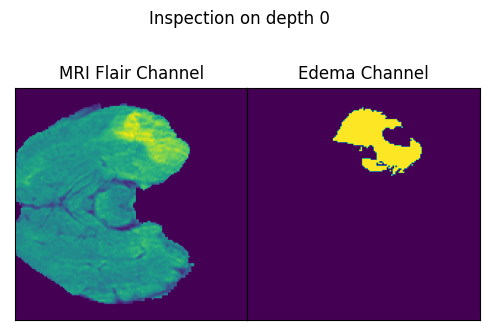

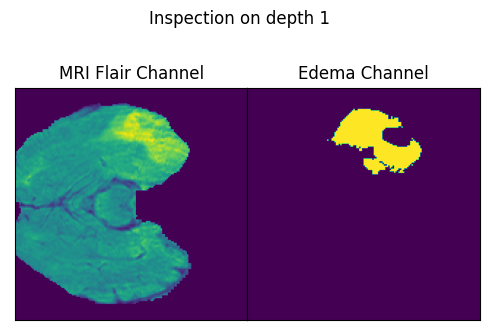

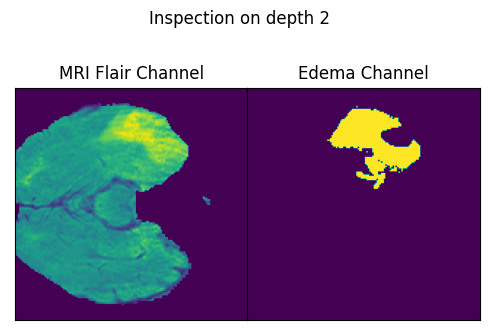

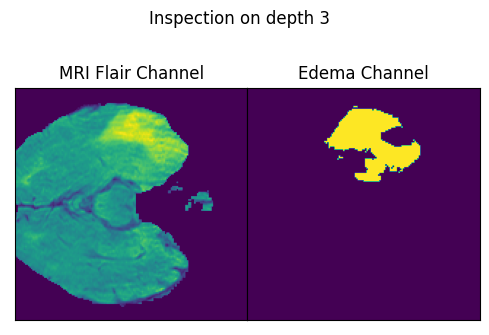

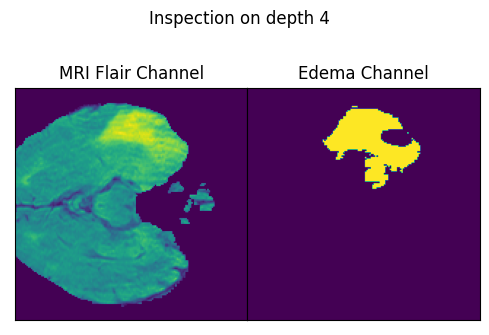

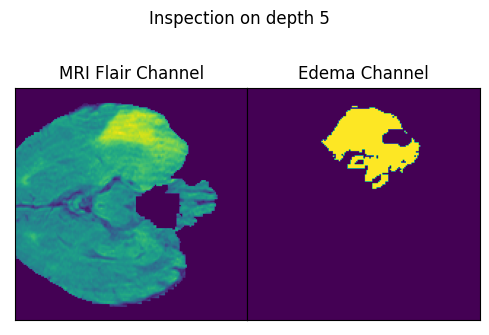

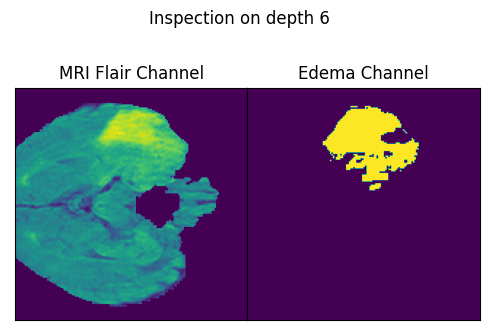

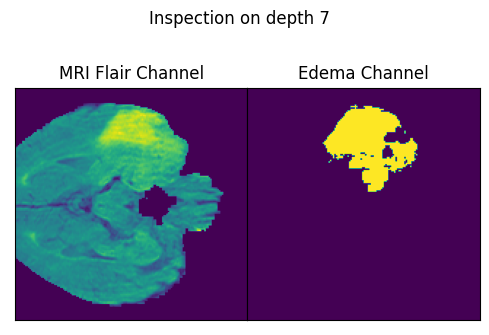

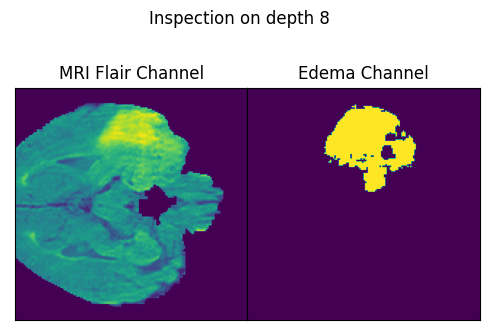

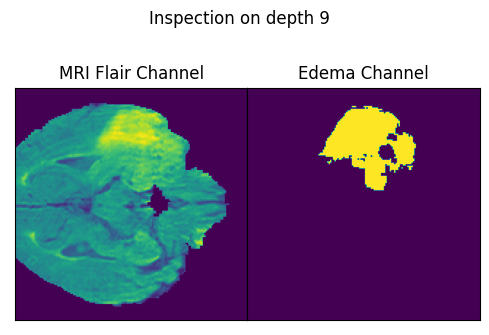

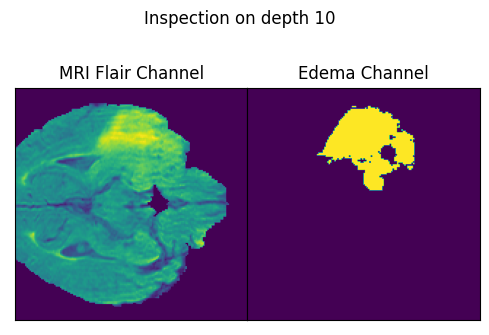

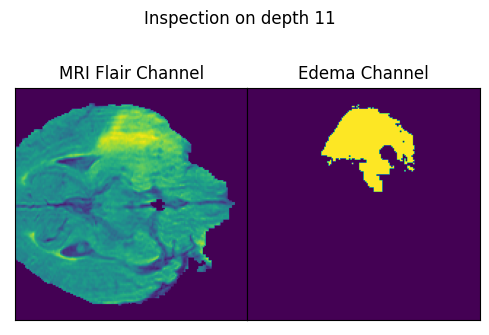

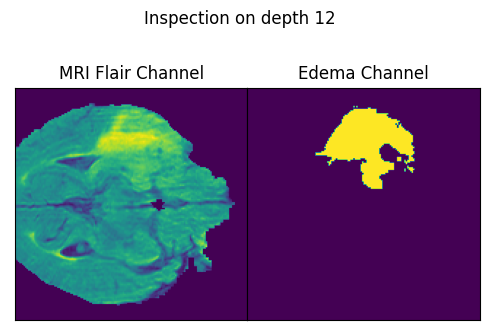

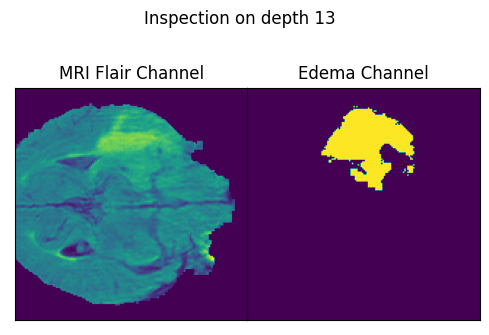

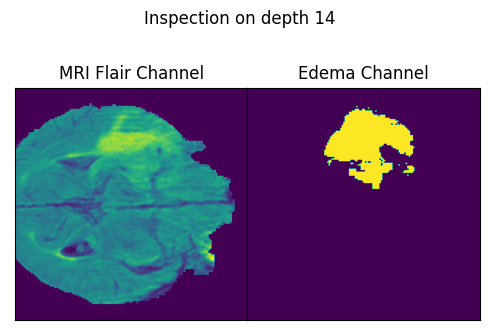

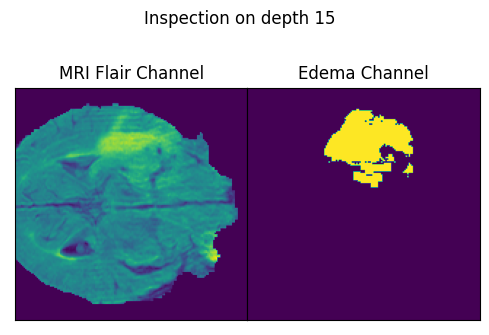

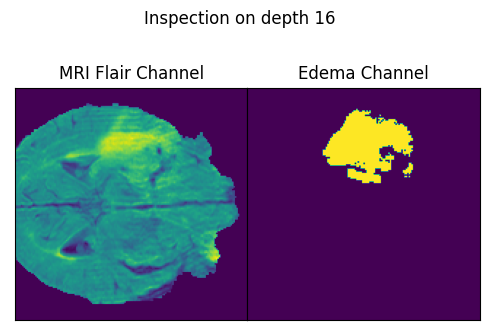

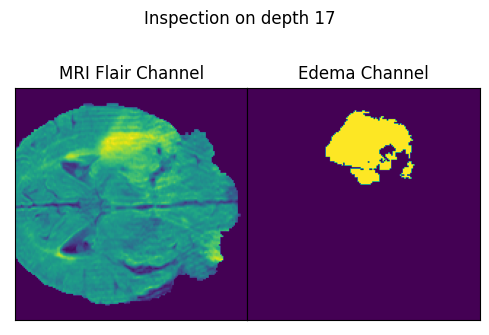

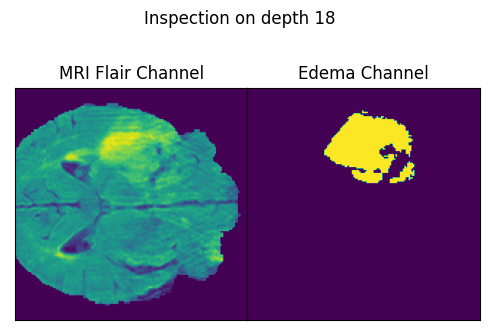

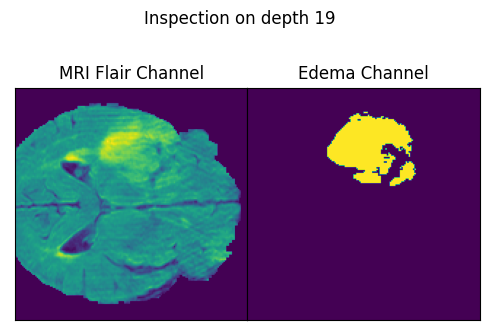

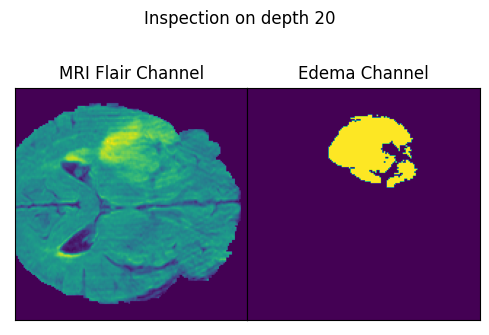

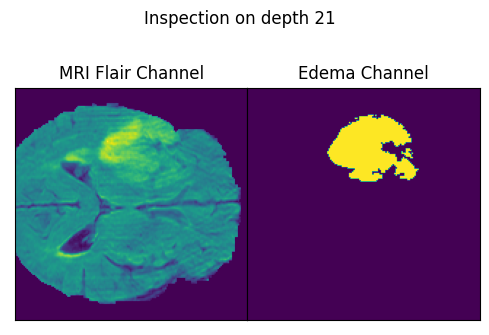

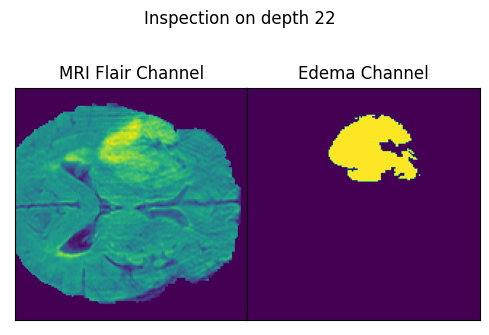

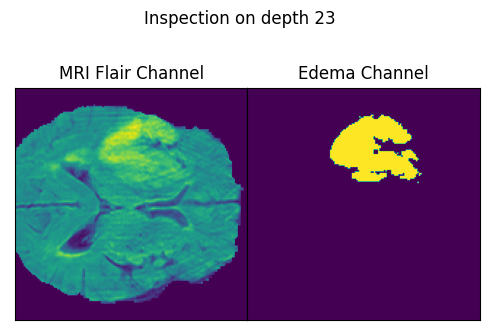

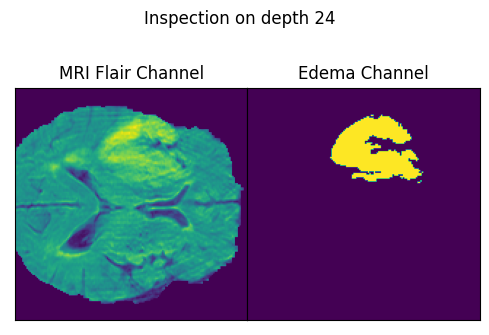

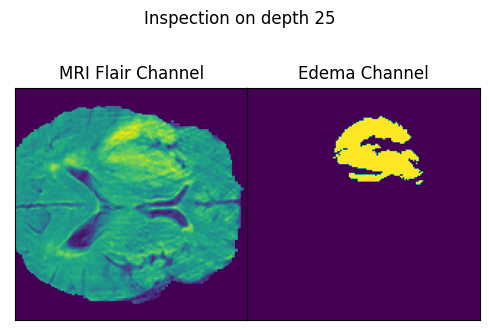

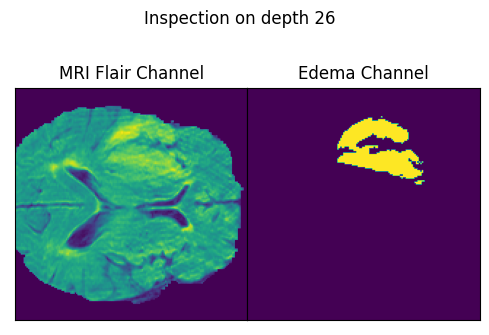

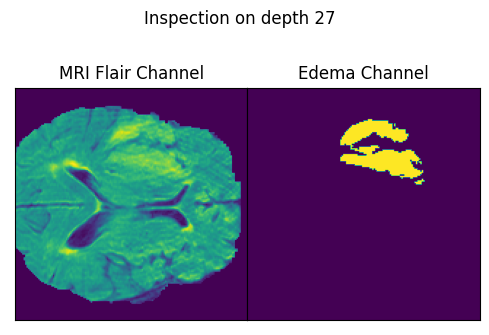

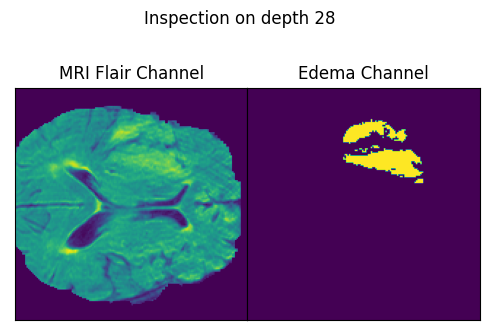

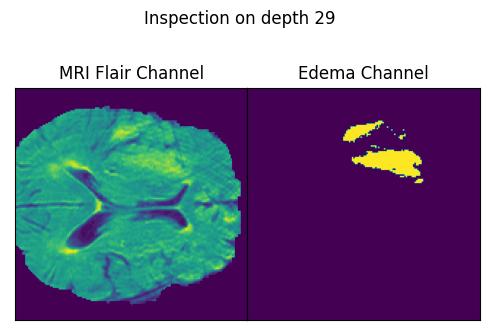

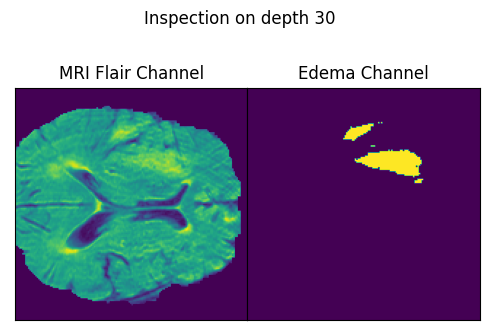

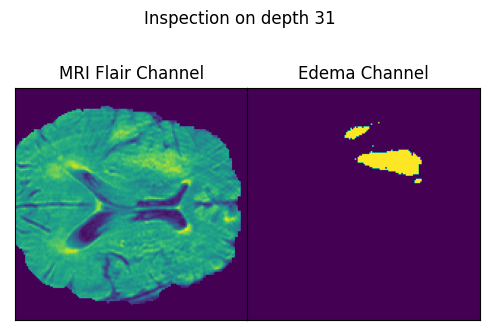

In [3]:
with open('../resources/BRATS_ds/config.json', "r")  as f:
        config = json.load(f)

img, mask = brats_datafiles.get_sub_volume(0, config, 'Train')
brats_datafiles.visualize_patch(img, mask)

In [ ]:
image, label = brats_datafiles.load_example(1)

In [ ]:
# Select random layer number
def explore_3dimage(layer, channel):
    plt.figure(figsize=(8, 5))
    #channel = 3
    plt.imshow(image[:, :, layer, channel], cmap='gray')
    plt.title('Explore Layers of Brain MRI', fontsize=10)
    plt.axis('off')
    return layer, channel


def explore_label_per_channel(layer):
    classes_dict = {
        'Normal': 0.,
        'Edema': 1.,
        'Non-enhancing tumor': 2.,
        'Enhancing tumor': 3. 
    }
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 20))
    for i in range(4):
        label_str = list(classes_dict.keys())[i]
        img = label[:,:,layer]
        mask = np.where(img == classes_dict[label_str], 255, 0)
        ax[i].imshow(mask)
        ax[i].set_title(f"{label_str}", fontsize=10)
        ax[i].axis('off')
    
    return layer


def explore_label(layer):
    classes_dict = {
        'Normal': 0.,
        'Edema': 1.,
        'Non-enhancing tumor': 2.,
        'Enhancing tumor': 3. 
    }
    plt.figure(figsize=(8, 5))
    #channel = 3
    plt.imshow(label[:, :, layer])
    plt.title('Explore Layers of Brain MRI', fontsize=10)
    plt.axis('off')
    return layer


The "depth" listed above indicates that there are 155 layers (slices through the brain) in every image object.
Note that if the layer is one of the first or the last (i near 0 or 154), you won't find much information and the screen will be dark.

In [ ]:
# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, image=image, layer=(10, image.shape[2] - 10), channel=(0, image.shape[-1]-1))
interact(explore_label, label=label, layer=(10, image.shape[2] - 30))
interact(explore_label_per_channel, label=label, layer=(10, image.shape[2] - 30), channel=(0, image.shape[-1]-1))

In [ ]:
brats_datafiles.plot_image_grid(2)

In [ ]:
def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        x = data_[min(i, data_.shape[0] - 1), :, :]
        y = data_[:, min(i, data_.shape[1] - 1), :]
        z = data_[:, :, min(i, data_.shape[2] - 1)]
        img = np.concatenate((x, y, z), axis=1)
        images.append(img)
    imageio.mimsave("/tmp/gif.gif", images, duration=0.01)
    return Image(filename="/tmp/gif.gif", format='png')

In [ ]:
visualize_data_gif(brats_datafiles.colorize_labels_image_flair(2))

In [ ]:
brats_datafiles.plot_nl(2)

Generate sub-volumes
We are going to first generate "patches" of our data which you can think of as sub-volumes of the whole MR images.

The reason that we are generating patches is because a network that can process the entire volume at once will simply not fit inside our current environment's memory/GPU.
Therefore we will be using this common technique to generate spatially consistent sub-volumes of our data, which can be fed into our network.
Specifically, we will be generating randomly sampled sub-volumes of shape [160, 160, 16] from our images.
Furthermore, given that a large portion of the MRI volumes are just brain tissue or black background without any tumors, we want to make sure that we pick patches that at least include some amount of tumor data.
Therefore, we are only going to pick patches that have at most 95% non-tumor regions (so at least 5% tumor).
We do this by filtering the volumes based on the values present in the background labels.

Standardization (mean 0, stdev 1)
Lastly, given that the values in MR images cover a very wide range, we will standardize the values to have a mean of zero and standard deviation of 1.

This is a common technique in deep image processing since standardization makes it much easier for the network to learn.

In [ ]:
X, y = brats_datafiles.get_sub_volume(tf.constant(4))
brats_datafiles.visualize_patch(X, y)

In [ ]:
m_name = "Unet3D"
model = unet_model_3d()

In [ ]:
with open('../resources/BRATS_ds/config.json') as f:
    config = json.load(f)

# Get generators for training and validation sets
train_generator = VolumeDataGenerator(config["Train"]['files'], "../resources/BRATS_ds/Train/", batch_size=3, dim=(160, 160, 32), verbose=1)
valid_generator = VolumeDataGenerator(config["Validation"]['files'], "../resources/BRATS_ds/Validation/", batch_size=3, dim=(160, 160, 32), verbose=1)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)
model.compile(optimizer=optimizer, loss=soft_dice_loss, metrics= [dice_coefficient, soft_dice_coefficient, precision,sensitivity, specificity])

checkpoint = tf.keras.callbacks.ModelCheckpoint("3d_unet_brats", monitor='val_loss', save_best_only=True)
logs_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callback_lst = [checkpoint, tf.keras.callbacks.TensorBoard(histogram_freq=1, log_dir=logs_dir)]

model.fit(train_generator,
        #steps_per_epoch=steps_per_epoch,
        epochs=2,
        use_multiprocessing=True,
        validation_data=valid_generator,
        callbacks=callback_lst,
        )
        #validation_steps=validation_steps)

In [ ]:
print(model.evaluate(valid_generator))
#val_loss, val_dice = model.evaluate(valid_generator)
#print(f"validation soft dice loss: {val_loss:.4f}")
#print(f"validation dice coefficient: {val_dice:.4f}")

In [ ]:
ds_train, ds_val = brats_datafiles.get_training_sets()
for elem, msk in ds_train.take(1):
    img = elem[0].numpy()
    label = msk[0].numpy()
    print(f"batch shape is {elem.shape}, type is {elem.dtype}")
    print(f"image shape is {img.shape}, type: {img.dtype}")
    print(f"label shape is {label.shape} type: {label.dtype}")
    brats_datafiles.visualize_patch(img, label)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs 

In [ ]:
loss, dice_coef, soft_dice_coef = model.evaluate(ds_test)
print(f"Average Dice Coefficient on test dataset = {dice_coef:.4f}")

In [ ]:
model.load_weights("my_model_pretrained.hdf5")
model.summary()

In [ ]:
def predict_and_viz(image, label, model, threshold, loc=(100, 100, 50)):
    image_labeled = colorize_labels_image_flair(image.copy(), label.copy())

    model_label = np.zeros([3, 320, 320, 160])

    for x in range(0, image.shape[0], 160):
        for y in range(0, image.shape[1], 160):
            for z in range(0, image.shape[2], 16):
                patch = np.zeros([4, 160, 160, 16])
                p = np.moveaxis(image[x: x + 160, y: y + 160, z:z + 16], 3, 0)
                patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p
                pred = model.predict(np.expand_dims(patch, 0))
                model_label[:, x:x + p.shape[1],
                y:y + p.shape[2],
                z: z + p.shape[3]] += pred[0][:, :p.shape[1], :p.shape[2],
                                      :p.shape[3]]

    model_label = np.moveaxis(model_label[:, 0:240, 0:240, 0:155], 0, 3)
    model_label_reformatted = np.zeros((240, 240, 155, 4))

    model_label_reformatted = to_categorical(label, num_classes=4).astype(
        np.uint8)

    model_label_reformatted[:, :, :, 1:4] = model_label

    model_labeled_image = colorize_labels_image_flair(image, model_label_reformatted,
                                            is_categorical=True)

    fig, ax = plt.subplots(2, 3, figsize=[10, 7])

    # plane values
    x, y, z = loc

    ax[0][0].imshow(np.rot90(image_labeled[x, :, :, :]))
    ax[0][0].set_ylabel('Ground Truth', fontsize=15)
    ax[0][0].set_xlabel('Sagital', fontsize=15)

    ax[0][1].imshow(np.rot90(image_labeled[:, y, :, :]))
    ax[0][1].set_xlabel('Coronal', fontsize=15)

    ax[0][2].imshow(np.squeeze(image_labeled[:, :, z, :]))
    ax[0][2].set_xlabel('Transversal', fontsize=15)

    ax[1][0].imshow(np.rot90(model_labeled_image[x, :, :, :]))
    ax[1][0].set_ylabel('Prediction', fontsize=15)

    ax[1][1].imshow(np.rot90(model_labeled_image[:, y, :, :]))
    ax[1][2].imshow(model_labeled_image[:, :, z, :])

    fig.subplots_adjust(wspace=0, hspace=.12)

    for i in range(2):
        for j in range(3):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])

    return model_label_reformatted

In [ ]:
test_ex_id = random.choice(brats_datafiles.test_ids)

In [ ]:
X_norm, y = brats_datafiles.get_sub_volume(tf.constant(test_ex_id))

X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
patch_pred = model.predict(X_norm_with_batch_dimension)
# set threshold.
threshold = 0.5

# use threshold to get hard predictions
patch_pred[patch_pred > threshold] = 1.0
patch_pred[patch_pred <= threshold] = 0.

print("Patch and ground truth")
brats_datafiles.visualize_patch(X_norm[0, :, :, :], y[2])
plt.show()
print("Patch and prediction")
brats_datafiles.visualize_patch(X_norm[0, :, :, :], patch_pred[0, 2, :, :, :])
plt.show()

In [ ]:
def get_sens_spec_df(pred, label):
    patch_metrics = pd.DataFrame(
        columns = ['Edema', 
                   'Non-Enhancing Tumor', 
                   'Enhancing Tumor'], 
        index = ['Sensitivity',
                 'Specificity'])
    
    for i, class_name in enumerate(patch_metrics.columns):
        sens, spec = compute_class_sens_spec(pred, label, i)
        patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
        patch_metrics.loc['Specificity', class_name] = round(spec,4)

    return patch_metrics

In [ ]:
image, label = brats_datafiles.load_example(test_ex_id)
pred = predict_and_viz(image, label, model, .5, loc=(130, 130, 77)) 

whole_scan_label = tf.keras.utils.to_categorical(label, num_classes = 4)
whole_scan_pred = pred

# move axis to match shape expected in functions
whole_scan_label = np.moveaxis(whole_scan_label, 3 ,0)[1:4]
whole_scan_pred = np.moveaxis(whole_scan_pred, 3, 0)[1:4]

whole_scan_df = get_sens_spec_df(whole_scan_pred, whole_scan_label)

print(whole_scan_df)